# Mass Balance Fitting : 

In [3]:
from MassBalanceModel import * 
from IPython.display import display, HTML

__Goals__: Outline the model parameters that:
- $\color{green}{ \text{Well know throughout the region}}$
- $\color{blue}{  \text{Determined by model results from Young et al. 2020 / Katie's work}}$
- $\color{red}{   \text{Free parameters that need to be fit as part of this study }}$


$\require{ulem}  
\require{color}$

-------

## Surface Mass Balance Model 

Following Gilbert et al [ 2016, ](test) [ 2020 ](test  )the annual net balance $B$ (kg m$^{-2}$  a$^{-1}$):
$$
\begin{equation}
    B(z) = A(z) + R(z) - M(z) ,
\end{equation}
$$
where:
- $A(z)$ is snow accumulation ( kg m$^{-2}$  a$^{-1}$ )
- $R(z)$ is rate of refreezing ( kg m$^{-2}$  a$^{-1}$ )
- $M(z)$ is surface ablation (melt) ( kg m$^{-2}$  a$^{-1}$ )


### Air Temperature Forcing 
Assuming the surface air temperature $T \textrm{  (K)}$ is modeled as: 

$$
\begin{equation}
    T(d,z) = \alpha \cos\left( \frac{2 \pi \left(d - \hat{T} \right) }{365} \right) + T_{\rm ma} + (z - z_{\rm ref}) \frac{d T}{dz} ,
\end{equation} 
$$

where:
- $\color{blue}{ \alpha}$ is the annual air temperature amplitude (K), 
- $\color{blue}{ T_{\rm ma}}$ is the mean annual air temperature at reference elevation $z_{\rm ref}$ (K) ,
- $\color{green}{ \frac{d T}{dz}}$ is the atmospheric lapse rate (K m$^{-1}$).
- $\color{blue}{ \hat{T}}$ is the DOY of air temperature peak (d)

,Value,Tuned
ΔTΔz,0.0065,False
α,10.5743,True
temp_peak,195.903,True
T_mean,-8.66503,True


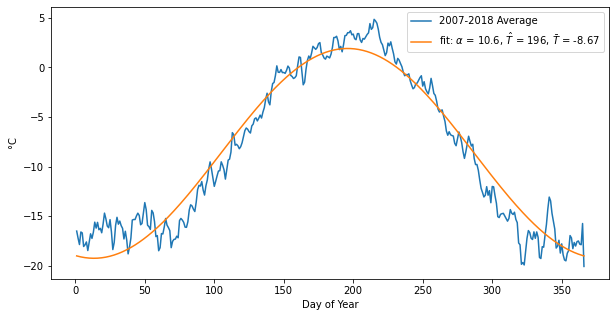

In [4]:
# Simple Fitting of air temperature forcing parameters to Katie's Model runs
Young2020 = xr.open_dataset("Young_etal_2020_Delta_T_-0.9_C.nc")

fit_airtemp(Young2020)

<ErrorbarContainer object of 3 artists>

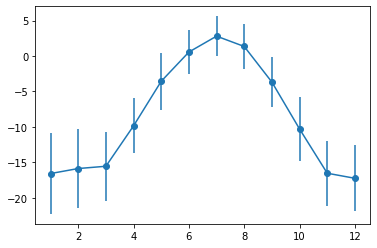

In [5]:
fig, ax = plt.subplots(1,1)

ax.scatter(Young2020.groupby("time.month").mean().month, Young2020.groupby("time.month").mean().temp)


ax.errorbar(Young2020.groupby("time.month").mean().month, 
            Young2020.groupby("time.month").mean().temp,
            Young2020.temp.groupby("time.month").std())

In [94]:
test = fit_airtemp(Young2020, plot=False)

In [96]:
test[0]

array([ 10.57431881, 195.90260946,  -8.66503452])

## Accumulation $A(z)$:

Snow accumulation $A(z)$ is modeled as: 

\begin{equation}
     A_{\rm snow}(z) = \sum^{365}_{d=1} 
    \begin{cases}
    \frac{P_{\rm ref}}{365} +( 1 +  (z-z_{\rm ref})) \frac{d P}{d z} & \text{if } T(d,z) < T_{\rm snow} ,\\
    0 & \text{if } T(d,z) \geq T_{\rm snow} ,
    \end{cases}
\end{equation}

where:
 - $\color{blue}{ P_{\rm ref}}$ is mean annual precipitation at reference elevation $z_{\rm ref}$  ( kg m$^{-2}$  a$^{-1}$ ) [<sup>1,</sup>](#fn1) [<sup>2</sup>](#fn2)
 - $\color{blue}{ \frac{d P}{d z}}$ altitudinal precipitation factor, $ \color{red}{Maybe???}$  ( m$^{-1}$ ) [<sup>1,</sup>](#fn1)
 - $\color{blue}{ T_{\rm snow}}$  snow versus rain temperature threshold  $(K)$


[<sup id="fn1">1</sup>](#fn1-back) Tuned by Gilbert et al. 2016  
[<sup id="fn2">2</sup>](#fn2-back) Tuned by Gilbert et al. 2020

## Melt $M(z)$: 

The annual melt $M(z)$ is modeled as 
\begin{equation}
    M_{\rm melt}(z) = \sum^{365}_{d=1} \max\left[ \left( T(d,z) - T_{\rm melt} \right) f_{\rm m}(x), 0\right] ,
\end{equation}
where: 
 - $\color{blue}{T_{\rm melt}}$ is the temperature threshold for melting (K) [<sup>2</sup>](#fn2)
 - $f_{\rm m}(x)$ is the nodally specific degree day factor described below ( kg m$^{-2}$  a$^{-1}$ K$^{-1}$) [<sup>1,</sup>](#fn1) [<sup>2</sup>](#fn2)

[<sup id="fn1">1</sup>](#fn1-back) Tuned by Gilbert et al. 2016  
[<sup id="fn2">2</sup>](#fn2-back) Tuned by Gilbert et al. 2020

## Refreezing $R(z)$: 

We assume refreezing from previous years creates impermeable layers, meaning refreezing can only occur to a depth at maximum equal the annual accumulation, such that:

\begin{equation}
    R(z) = \min \left[ M_{\rm melt}(z), f_{\rm r} A_{\rm snow}(z) \right], 
\end{equation}
where:
- $\color{red}{f_{\rm r}}$ is the refreezing factor (the proportion of annual melt that refreezes) [-]. [<sup>1,</sup>](#fn1) [<sup>2</sup>](#fn2)
    - Think about elevation dependence (or mean annual air temp) of $f_r$ account for variability in different elevation accumulation areas,  since it's the factor that influence latent heat. 

[<sup id="fn1">1</sup>](#fn1-back) Tuned by Gilbert et al. 2016  
[<sup id="fn2">2</sup>](#fn2-back) Tuned by Gilbert et al. 2020

## Degree Day Factor $f_{\rm m}(x)$:  

We calculate the nodal degree day factor as:

\begin{equation}
    f_{\rm m}(z) = 
    \begin{cases}
        f_{\rm snow}                                          & \text{if } r_{\rm s/m}(z) \geq 1 , \\
        f_{\rm ice} - (f_{\rm ice} - f_{\rm snow})r_{\rm s/m}(z) & \text{if } r_{\rm s/m}(z) < 1 ,\\
    \end{cases}
\end{equation}
where
\begin{equation}
    r_{\rm s/m}(z) = \frac{A(z)}{M(z)} . 
\end{equation}
- $\color{red}{f_{\rm ice} }$  is the degree day factor for ice  ( kg m$^{-2}$  a$^{-1}$ K$^{-1}$) [<sup>1,</sup>](#fn1) [<sup>2</sup>](#fn2)
- $\color{red}{f_{\rm snow} }$ is the degree day factor for snow ( kg m$^{-2}$  a$^{-1}$ K$^{-1}$) [<sup>1,</sup>](#fn1) [<sup>2</sup>](#fn2)


[<sup id="fn1">1</sup>](#fn1-back) Tuned by Gilbert et al. 2016  
[<sup id="fn2">2</sup>](#fn2-back) Tuned by Gilbert et al. 2020

<!-- The nodal specific $f_{\rm m}$ should be bounded by $f_{\rm ice}$ and $f_{\rm snow}$. -->

## Parameter Fitting: 

Formulate as an constrained optimization problem:

$$
\begin{gathered}
\min          && ||\hat{B}(x, f_{\rm ice}, f_{\rm snow}, f_{\rm r},  \frac{d P}{d z}) - B_{\rm elmer}(z) || \\
\textrm{subject to:} && 0 < f_{\rm ice} < \inf \\
                     && 0 < f_{\rm snow} < \inf \\
                     && 0 < f_{\rm r} < 0.6  \\
                     %&& 0 < \frac{d P}{d z} < \inf \\
                     && f_{\rm snow} \leq f_{\rm ice}
\end{gathered}
$$



/Users/andrewnolan/OneDrive - Simon Fraser University (1sfu)/thermal-structure/study/MB_tune/notebooks/MassBalanceModel.py:89: RuntimeWarning: divide by zero encountered in true_divide
  r_s2m = np.where(melt_local==0.0, 1, A_snow / melt_local)
/Users/andrewnolan/OneDrive - Simon Fraser University (1sfu)/thermal-structure/study/MB_tune/notebooks/MassBalanceModel.py:89: RuntimeWarning: divide by zero encountered in true_divide
  r_s2m = np.where(melt_local==0.0, 1, A_snow / melt_local)


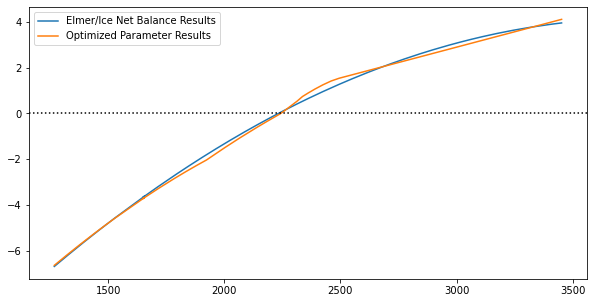

In [3]:
popt, pcov = fit_airtemp(Young2020, plot=False)

opt = optimizer(popt)

x0 = [0.0, 0.0, 0.0, 0.0]

bounds = optimize.Bounds(0.0, [np.inf, np.inf, 0.6, np.inf]) 

linear_constraint = optimize.LinearConstraint([[1, -1, 0, 0]], [0], [np.inf])

res = optimize.minimize(opt.objective, x0, tol=1e-9, 
                        constraints=[linear_constraint],
                        bounds=bounds)

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(src.Z.isel(t=-1, coord_2=-1).values,  
        src["zs accumulation flux 2"].isel(t=-1, coord_2=-1).values,
        label="Elmer/Ice Net Balance Results")
ax.plot(src.Z.isel(t=-1, coord_2=-1).values,  
        opt.forward(res.x),
        label="Optimized Parameter Results")

ax.axhline(0, ls=":", c='k')

ax.legend()

In [37]:
z  = src.Z.isel(t=-1, coord_2=-1).values[np.newaxis, :]
MB = src["zs accumulation flux 2"].isel(t=-1, coord_2=-1).values
z_ref = np.nanmean(Young2020.stack(z=('x', 'y')).Elevation.values)
A_mean = Young2020.stack(z=('x', 'y')).Accumulation.values[
          np.argpartition(np.abs(Young2020.stack(z=('x', 'y')).Elevation.values - z_ref), 25)][:25].mean() * 910.0

In [41]:
import pickle


with open("../dict.pickle","wb") as src: 
    
    pickle.dump(dict(Z=z, MB=MB, z_ref=z_ref, A_mean=A_mean), src)


- Bayes would be better!

https://furnstahl.github.io/Physics-8820/notebooks/Machine_learning/Bayesian_optimization.html

https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/B0468287399CE6B538FA834AB3B77341/S0260305516000033a.pdf/inversion-of-a-glacier-hydrology-model.pdf

https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/61D8956E9A6C27CC1A5AEBFCDADC0432/S0022143019000911a.pdf/quantifying_parameter_uncertainty_in_a_largescale_glacier_evolution_model_using_bayesian_inference_application_to_high_mountain_asia.pdf

In [36]:
Young2020.stack(z=('x', 'y')).Elevation.mean().values

array(2193.00864293)